<a href="https://colab.research.google.com/github/qudgns147/amon/blob/master/%EC%9E%90%EC%A0%84%EA%B1%B0_%EB%8C%80%EC%9A%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [49]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

mpl.rcParams['axes.unicode_minus'] = False

import warnings 
warnings.filterwarnings('ignore')

In [59]:
train = pd.read_csv('/content/drive/MyDrive/Bike_sharing_demand/bike-sharing-demand/train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [60]:
test=pd.read_csv('/content/drive/MyDrive/Bike_sharing_demand/bike-sharing-demand/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

In [61]:
train["year"] = train['datetime'].dt.year
train["month"] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['dayofweek'] = train.datetime.dt.dayofweek

In [62]:
train.shape
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,5


In [63]:
test["year"] = test['datetime'].dt.year
test["month"] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['dayofweek'] = test.datetime.dt.dayofweek

In [13]:
test.shape

(6493, 15)

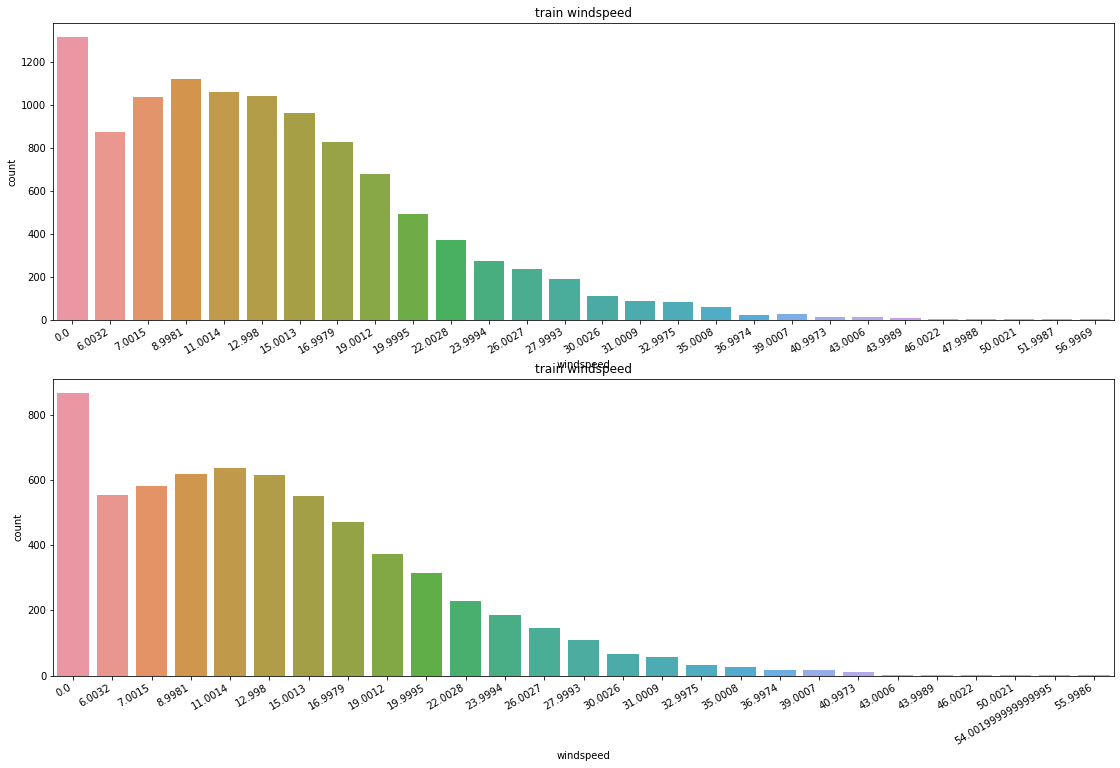

In [64]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(19,12)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel = 'Count', title = 'train windspeed')
sns.countplot(data=train, x='windspeed', ax= axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel = 'Count', title = 'train windspeed')
sns.countplot(data=test, x='windspeed', ax= axes[1])


In [19]:
trainwind0 = train.loc[train['windspeed'] == 0]
trainwindnot0 = train.loc[train['windspeed']!= 0]
print(trainwind0.shape)
print(trainwindnot0.shape)


(1313, 18)
(9573, 18)


In [65]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터 타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data


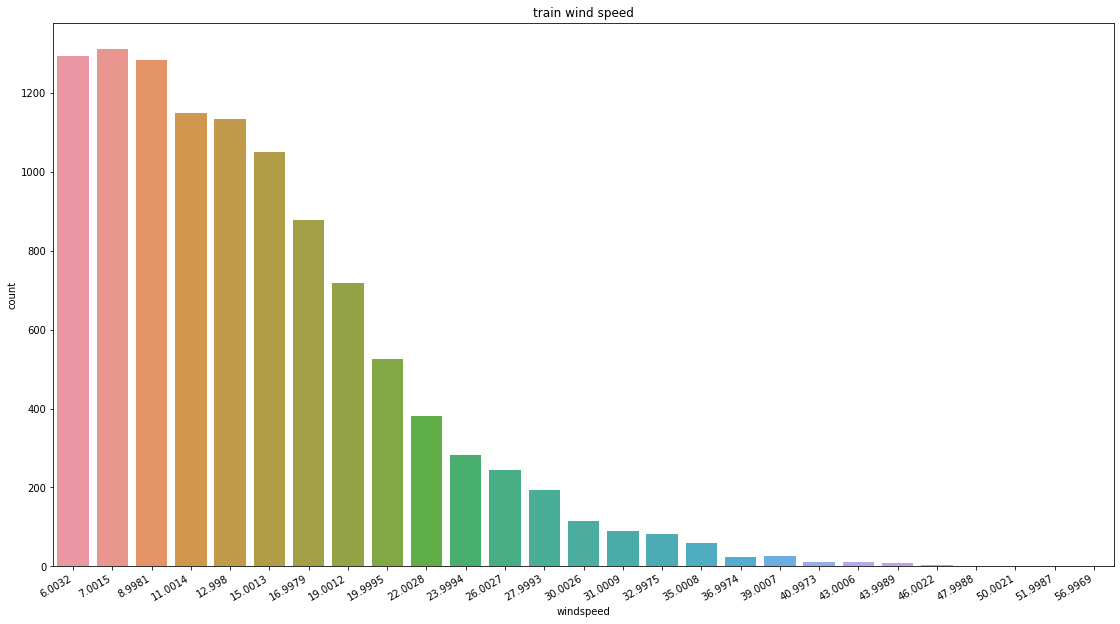

In [66]:
train = predict_windspeed(train)

fig, ax1=  plt.subplots()
fig.set_size_inches(19, 10)

plt.sca(ax1)
plt.xticks(rotation=30, ha = 'right')
ax1.set(ylabel = 'count' , title = 'train wind speed')
sns.countplot(data=train, x='windspeed', ax=ax1)

In [67]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,dayofweek
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,0,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,0,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011,1,1,11,0,5
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011,1,1,12,0,5
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011,1,1,13,0,5


In [68]:
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for var in categorical_feature_names:
  train[var] = train[var].astype('category')
  test[var] = test[var].astype('category')

In [73]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity','windspeed', 'year','hour','dayofweek','holiday','workingday']
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [74]:
x_train = train[feature_names]

print(x_train.shape)
x_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [75]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [76]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [77]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [78]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [79]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [85]:
%time score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 2.6 s, sys: 512 ms, total: 3.11 s
Wall time: 27.9 s
Score= 0.33050


In [86]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습함
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [87]:
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.34,   5.03,   4.23,   3.65,   3.21,   6.29,  38.31, 105.44,
       236.02, 135.5 ])

[Text(0.5, 1.0, 'test')]

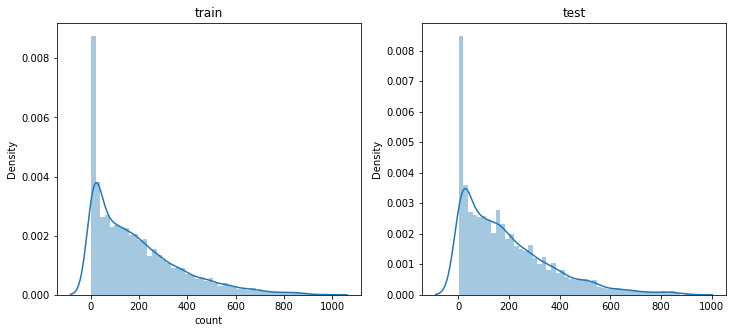

In [88]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

In [89]:
submission = pd.read_csv('/content/drive/MyDrive/Bike_sharing_demand/bike-sharing-demand/sampleSubmission.csv')
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.34
1,2011-01-20 01:00:00,5.03
2,2011-01-20 02:00:00,4.23
3,2011-01-20 03:00:00,3.65
4,2011-01-20 04:00:00,3.21


In [91]:
submission.to_csv("/content/drive/MyDrive/Bike_sharing_demand/bike-sharing-demand/Score_{0:.5f}_submission.csv".format(score), index=False)